<a href="https://colab.research.google.com/github/Sara1428/Deep-RL-for-Optimizing-Stock-Returns/blob/main/dqn_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque

In [2]:
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.state = (0, 0)
        self.goal = (size - 1, size - 1)
        self.obstacles = [(1, 1), (1, 3), (3, 1)]
        self.reset()

    def reset(self):
        self.state = (0, 0)
        return self.state

    def step(self, action):
        x, y = self.state

        if action == 0:  # Up
            x = max(0, x - 1)
        elif action == 1:  # Down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Left
            y = max(0, y - 1)
        elif action == 3:  # Right
            y = min(self.size - 1, y + 1)

        if (x, y) in self.obstacles:
            x, y = self.state

        self.state = (x, y)
        reward = 1 if self.state == self.goal else -0.01
        done = self.state == self.goal

        return self.state, reward, done

    def available_actions(self):
        return [0, 1, 2, 3]

In [3]:
class DQN:
    def __init__(self, state_size, action_size):
        self.model = self.build_model(state_size, action_size)

    def build_model(self, state_size, action_size):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(24, activation='relu', input_shape=(state_size,)),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')
        return model

    def predict(self, state):
        return self.model.predict(state)

    def fit(self, state, target):
        self.model.fit(state, target, epochs=1, verbose=0)

In [18]:
# Parameters
num_episodes = 50
discount_factor = 0.99
exploration_rate = 1.0
exploration_decay = 0.995
min_exploration_rate = 0.01
replay_buffer = deque(maxlen=2000)
batch_size = 10

# Initialize environment and DQN
env = GridWorld()
state_size = 2  # (x, y)
action_size = 4
dqn = DQN(state_size, action_size)

In [19]:
# Training loop
rewards = []
for episode in range(num_episodes):
    state = env.reset()
    state = np.array(state).reshape(1, -1)
    total_reward = 0

    for step in range(10):
        if random.uniform(0, 1) < exploration_rate:
            action = random.choice(env.available_actions())
        else:
            q_values = dqn.predict(state)
            action = np.argmax(q_values[0])

        next_state, reward, done = env.step(action)
        next_state = np.array(next_state).reshape(1, -1)
        total_reward += reward

        # Store in replay buffer
        replay_buffer.append((state, action, reward, next_state, done))

        if len(replay_buffer) > batch_size:
            mini_batch = random.sample(replay_buffer, batch_size)
            for s, a, r, s_next, d in mini_batch:
                target = dqn.predict(s)
                if d:
                    target[0][a] = r
                else:
                    target[0][a] = r + discount_factor * np.max(dqn.predict(s_next)[0])
                dqn.fit(s, target)
        print(step,"===================================================")
        state = next_state
        if done:
          break
    print(episode, "------------------------------------------------")
    rewards.append(total_reward)
    exploration_rate = max(min_exploration_rate, exploration_rate * exploration_decay)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step
4 ===================================================
1/1 [==============================] - 0s 28ms/step
5 ===================================================
1/1 [==============================] - 0s 40ms/step
6 ===================================================
1/1 [==============================] - 0s 31ms/step
7 ===================================================
1/1 [==============================] - 0s 30ms/step
8 ===================================================
1/1 [==============================] - 0s 28ms/step
9 ===================================================
26 ------------------------------------------------
1/1 [==============================] - 0s 45ms/step
0 ===================================================
1/1 [==============================] - 0s 31ms/step
1 ===================================================
1/1 [==============================] - 0s 33ms/st

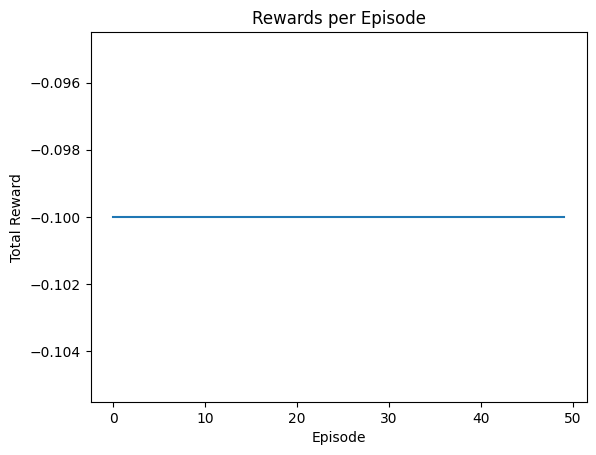

In [20]:
# Plotting results
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode')
plt.show()